In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision as tv

import os
import cv2
import numpy as np
import yaml
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

from torch.cuda.amp import autocast, GradScaler

In [76]:
option_path = 'config.yml'
with open(option_path, 'r') as file_option:
    option = yaml.safe_load(file_option)

In [77]:
option

{'batch_size': 16,
 'train_dogs_path': './dataset/test_set/dogs/',
 'train_cats_path': './dataset/test_set/cats/',
 'test_dogs_path': './dataset/training_set/dogs/',
 'test_cats_path': './dataset/training_set/cats/',
 'network': {'in_nc': 3, 'base_nc': 32, 'out_nc': 2}}

In [78]:
class Dataset2class(torch.utils.data.Dataset):
    def __init__(self, path_dir1:str, path_dir2:str):
        super().__init__()
        
        self.path_dir1 = path_dir1
        self.path_dir2 = path_dir2
        
        self.dir1_list = sorted(os.listdir(path_dir1))
        self.dir2_list = sorted(os.listdir(path_dir2))
        
    def __len__(self):
        return len(self.dir1_list) + len(self.dir2_list)
    
    def __getitem__(self, idx):
        
        if idx < len(self.dir1_list):
            class_id = 0
            img_path = os.path.join(self.path_dir1, self.dir1_list[idx])
        else:
            class_id = 1
            idx -= len(self.dir1_list)
            img_path = os.path.join(self.path_dir2, self.dir2_list[idx])
        
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)
        img = img/255.0
        
        img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)
        img = img.transpose((2, 0, 1))
        
        t_img = torch.from_numpy(img)
        t_class_id = torch.tensor(class_id)
        
        return {'img': t_img, 'label': t_class_id}
        

In [79]:
train_dogs_path = option['train_dogs_path'] # './dataset/training_set/dogs/'
train_cats_path = option['train_cats_path'] # './dataset/training_set/cats/'
test_dogs_path = option['test_dogs_path']  # './dataset/test_set/dogs/'
test_cats_path = option['test_cats_path'] # './dataset/test_set/cats/'

train_ds_catsdogs = Dataset2class(train_dogs_path, train_cats_path)
test_ds_catsdogs = Dataset2class(test_dogs_path, test_cats_path)

In [80]:
len(train_ds_catsdogs)

2000

In [81]:
len(test_ds_catsdogs)

8000

In [82]:
batch_size = option['batch_size']

train_loader = torch.utils.data.DataLoader(
    train_ds_catsdogs, shuffle=True, 
    batch_size=batch_size, num_workers=1, drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    train_ds_catsdogs, shuffle=True,
    batch_size=batch_size, num_workers=1, drop_last=False
)

In [83]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.act = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool2d(2,2)
        self.conv0 = nn.Conv2d(3, 128, 3, stride=1, padding=0)
        self.conv1 = nn.Conv2d(128, 128, 3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(128, 128, 3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(128, 256, 3, stride=1, padding=0)
        
        self.adaptivepool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(256, 20)
        self.linear2 = nn.Linear(20, 2)
        
    def forward(self, x):
        

        out = self.conv0(x)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv1(out)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv2(out)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv3(out)
        out = self.act(out)
        
        out = self.adaptivepool(out)
        out = self.flatten(out)
        out = self.linear1(out)
        out = self.act(out)
        out = self.linear2(out)

        return out
        

In [84]:
class ResBlock(nn.Module):
    def __init__(self, nc):
        super().__init__()
        
        self.conv0 = nn.Conv2d(nc, nc, kernel_size=3, padding=1)
        self.norm0 = nn.BatchNorm2d(nc)
        self.act = nn.LeakyReLU(0.2)
        self.conv1 = nn.Conv2d(nc, nc, kernel_size=3, padding=1)
        self.norm1 = nn.BatchNorm2d(nc)
        
    def forward(self, x):
        out = self.conv0(x)
        out = self.norm0(out)
        out = self.act(out)
        out = self.conv1(out)
        #out = self.norm1(out)
        
        return x + out # self.act(x + out)

In [85]:
class BottleneckBlock(nn.Module):
    def __init__(self, nc):
        super().__init__()
        self.act = nn.LeakyReLU(0.2)
        
        self.conv0 = nn.Conv2d(nc, nc//4, kernel_size=1, padding=0)
        self.norm0 = nn.BatchNorm2d(nc//4)
        self.conv1 = nn.Conv2d(nc//4, nc//4, kernel_size=3, padding=1)
        self.norm1 = nn.BatchNorm2d(nc//4)
        self.conv2 = nn.Conv2d(nc//4, nc, kernel_size=1, padding=0)
        
    def forward(self, x):
        out = self.conv0(x)
        out = self.norm0(out)
        out = self.act(out)
        out = self.conv1(out)
        out = self.norm1(out)
        out = self.act(out)
        out = self.conv2(out)
        
        return x + out # self.act(x + out)

In [86]:
class ResTruck(nn.Module):
    def __init__(self, nc, num_blocks, block_type='classic'):
        super().__init__()
        
        truck = []
        for i in range(num_blocks):
            if block_type == 'classic':
                truck += [ResBlock(nc)]
            elif block_type == 'bottleneck':
                truck += [BottleneckBlock(nc)]
            else:
                raise NotImplementedError(f'{block_type} is not implemented')
        self.truck = nn.Sequential(*truck)
        
    def forward(self, x):
        return self.truck(x)

In [87]:
class PsevoResNet(nn.Module):
    def __init__(self, in_nc, nc, out_nc, block_type):
        super().__init__()
        
        self.conv0 = nn.Conv2d(in_nc, nc, kernel_size=7, stride=2)
        #self.norm
        self.act = nn.LeakyReLU(0.2, inplace=True)
        self.maxpool = nn.MaxPool2d(2,2)
        
        self.layer1 = ResTruck(nc, 3, block_type=block_type)
        self.conv1 = nn.Conv2d(nc, 2*nc, 3, padding=1, stride=2)
        self.layer2 = ResTruck(2*nc, 4, block_type=block_type)
        self.conv2 = nn.Conv2d(2*nc, 4*nc, 3, padding=1, stride=2)
        self.layer3 = ResTruck(4*nc, 6, block_type=block_type)
        self.conv3 = nn.Conv2d(4*nc, 4*nc, 3, padding=1, stride=2)
        self.layer4 = ResTruck(4*nc, 3, block_type=block_type)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(4*nc, out_nc)
        
    def forward(self, x):
        out = self.conv0(x)
        out = self.act(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.conv1(out)
        out = self.layer2(out)
        out = self.conv2(out)
        out = self.layer3(out)
        out = self.conv3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out)
        out = self.flatten(out)
        out = self.linear(out)
        
        return out

In [88]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [89]:
in_nc = option['network']['in_nc']
base_nc = option['network']['base_nc']
out_nc = option['network']['out_nc']
model = PsevoResNet(in_nc, base_nc, out_nc, block_type='classic')

In [91]:
model

PsevoResNet(
  (conv0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2))
  (act): LeakyReLU(negative_slope=0.2, inplace=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer1): ResTruck(
    (truck): Sequential(
      (0): ResBlock(
        (conv0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): LeakyReLU(negative_slope=0.2)
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ResBlock(
        (conv0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): LeakyReLU(negative_slope=0.2)
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=

In [92]:
count_parameters(model)

3258370

In [93]:
for sample in train_loader:
    img = sample['img']
    label = sample['label']
    model(img)
    break

In [94]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer,
    gamma = 0.6
)

In [95]:
def accuracy(pred, label):
    answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1) 
    return answer.mean()

In [96]:
device = 'cuda' # if torch.cuda.is_available() else 'cpu'
model = model.to(device)
loss_fn = loss_fn.to(device)

In [97]:
use_amp = True
scaler = torch.cuda.amp.GradScaler()

In [98]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

In [99]:
epochs = 10
loss_epochs_list = []
acc_epochs_list = []
for epoch in range(epochs):
    loss_val = 0
    acc_val = 0
    for sample in (pbar := tqdm(train_loader)):
        img, label = sample['img'], sample['label']
        label = F.one_hot(label, 2).float()
        img = img.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        
        with autocast(use_amp):
            pred = model(img)
            loss = loss_fn(pred, label)

        scaler.scale(loss).backward()
        loss_item = loss.item()
        loss_val += loss_item

        scaler.step(optimizer)
        scaler.update()

        acc_current = accuracy(pred.cpu().float(), label.cpu().float())
        acc_val += acc_current

        pbar.set_description(f'loss: {loss_item:.5f}\taccuracy: {acc_current:.3f}')
    scheduler.step()
    loss_epochs_list += [loss_val/len(train_loader)]
    acc_epochs_list += [acc_val/len(train_loader)]
    print(loss_epochs_list[-1])
    print(acc_epochs_list[-1])

  0%|                                                   | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_11554/156703249.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)
loss: 0.91081	accuracy: 0.375: 100%|██████████| 125/125 [00:06<00:00, 19.86it/s]


0.9695049781799316
0.486


loss: 0.78491	accuracy: 0.500: 100%|██████████| 125/125 [00:06<00:00, 19.87it/s]


0.7102525100708008
0.52


loss: 0.57529	accuracy: 0.812: 100%|██████████| 125/125 [00:06<00:00, 19.09it/s]


0.6652804260253906
0.6005


loss: 0.60020	accuracy: 0.750:   7%|▊           | 9/125 [00:00<00:06, 17.17it/s]


KeyboardInterrupt: 

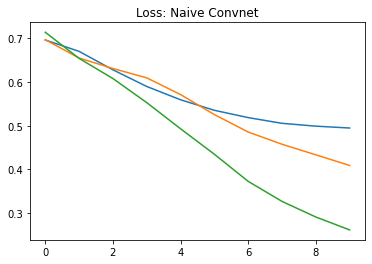

In [273]:
plt.title('Loss: Naive Convnet')
plt.plot(loss_epochs_list_naive)
plt.plot(loss_epochs_list_resnet_v1)
plt.plot(loss_epochs_list)

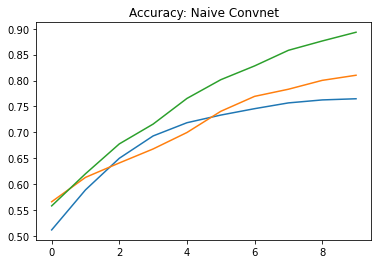

In [274]:
plt.title('Accuracy: Naive Convnet')
plt.plot(acc_epochs_list_naive)
plt.plot(acc_epochs_list_resnet_v1)
plt.plot(acc_epochs_list)

In [49]:
yaml.

<module 'yaml' from '/home/magorokhoov/pyenv/py310/lib/python3.10/site-packages/yaml/__init__.py'>